Team coefficients saved to team_coefficients.csv


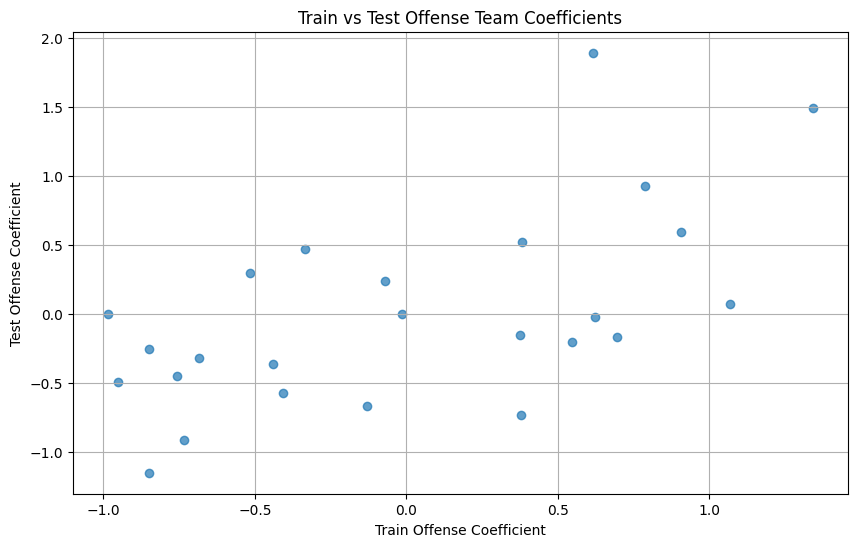

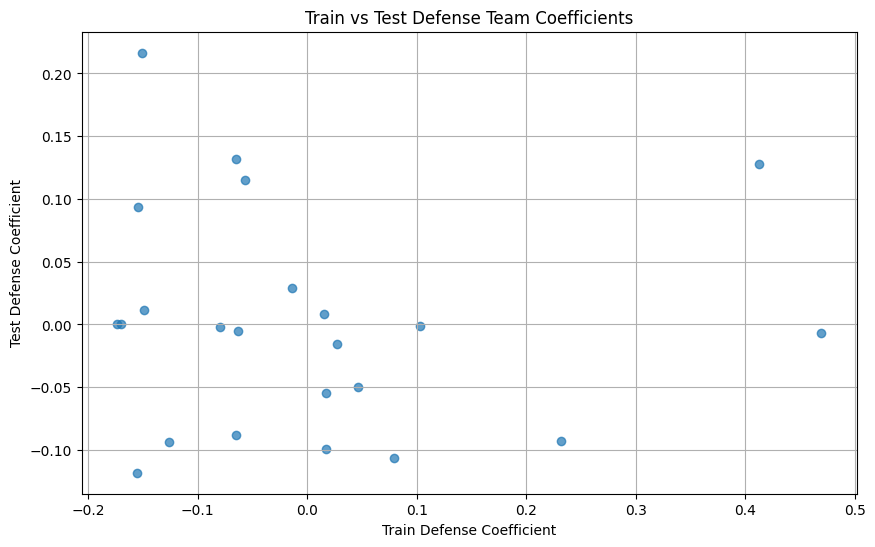

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv('drives.csv')

# ---------------------------
# Split data by week (train: weeks < 8, test: weeks >= 8)
# ---------------------------
df_train = df[df['week'] < 8].copy()
df_test  = df[df['week'] >= 8].copy()

# ---------------------------
# Filter teams with at least 25 drives in both train and test splits
# ---------------------------
# For offense
off_train_counts = df_train['offense_idx'].value_counts()
off_test_counts  = df_test['offense_idx'].value_counts()
valid_off_teams = off_train_counts[off_train_counts >= 25].index.intersection(off_test_counts[off_test_counts >= 25])

# For defense
def_train_counts = df_train['defense_idx'].value_counts()
def_test_counts  = df_test['defense_idx'].value_counts()
valid_def_teams = def_train_counts[def_train_counts >= 25].index.intersection(def_test_counts[def_test_counts >= 25])

# Filter data for valid teams
df_train_off = df_train[df_train['offense_idx'].isin(valid_off_teams)].copy()
df_test_off  = df_test[df_test['offense_idx'].isin(valid_off_teams)].copy()

df_train_def = df_train[df_train['defense_idx'].isin(valid_def_teams)].copy()
df_test_def  = df_test[df_test['defense_idx'].isin(valid_def_teams)].copy()

# ---------------------------
# Define features and targets
# ---------------------------
features = ['start_period', 'score_diff_start', 'is_home_offense', 'distance_to_goal', 'goal_to_go']

# Offense: predicting points scored by offense
offense_target = 'points_scored_offense'
# Defense: predicting points scored by defense (or points allowed)
defense_target = 'points_scored_defense'

# ---------------------------
# OFFENSE COEFFICIENTS
# ---------------------------
# Create dummy variables for offense teams with reset index
offense_encoded_train = pd.get_dummies(df_train_off['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)
offense_encoded_test  = pd.get_dummies(df_test_off['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)

# Build design matrices: combine team dummies and other features (reset index on features too)
X_train_off = pd.concat([offense_encoded_train, df_train_off[features].reset_index(drop=True)], axis=1)
X_test_off  = pd.concat([offense_encoded_test,  df_test_off[features].reset_index(drop=True)], axis=1)

# Align test columns to train columns (fill missing with 0)
X_test_off = X_test_off.reindex(columns=X_train_off.columns, fill_value=0)

y_train_off = df_train_off[offense_target].reset_index(drop=True)
y_test_off  = df_test_off[offense_target].reset_index(drop=True)

# Fit Ridge regression on training data
ridge_off = Ridge(alpha=1.0)
ridge_off.fit(X_train_off, y_train_off)

# Extract team coefficients from Ridge (first n columns corresponding to offense dummies)
n_offense = offense_encoded_train.shape[1]
offense_coeff_train = pd.Series(ridge_off.coef_[:n_offense], index=offense_encoded_train.columns)

# Fit Ridge regression on test data
ridge_off_test = Ridge(alpha=1.0)
ridge_off_test.fit(X_test_off, y_test_off)
offense_coeff_test = pd.Series(ridge_off_test.coef_[:n_offense], index=offense_encoded_train.columns)

# Create team name mapping for offense
team_name_map_off = df[['offense_idx', 'offense']].drop_duplicates().set_index('offense_idx')['offense'].astype(str).to_dict()

# Build offense coefficients DataFrame
offense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in offense_coeff_train.index],
    'team_name': [team_name_map_off.get(int(col.split('_')[-1]), 'Unknown') for col in offense_coeff_train.index],
    'train_offense_coeff': offense_coeff_train.values,
    'test_offense_coeff': offense_coeff_test.values
})

# ---------------------------
# DEFENSE COEFFICIENTS
# ---------------------------
# Create dummy variables for defense teams with reset index
defense_encoded_train = pd.get_dummies(df_train_def['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)
defense_encoded_test  = pd.get_dummies(df_test_def['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)

# Build design matrices: combine team dummies and features (reset index on features)
X_train_def = pd.concat([defense_encoded_train, df_train_def[features].reset_index(drop=True)], axis=1)
X_test_def  = pd.concat([defense_encoded_test,  df_test_def[features].reset_index(drop=True)], axis=1)

# Align test columns to train columns
X_test_def = X_test_def.reindex(columns=X_train_def.columns, fill_value=0)

y_train_def = df_train_def[defense_target].reset_index(drop=True)
y_test_def  = df_test_def[defense_target].reset_index(drop=True)

# Fit Ridge regression on training data for defense
ridge_def = Ridge(alpha=1.0)
ridge_def.fit(X_train_def, y_train_def)

n_defense = defense_encoded_train.shape[1]
defense_coeff_train = pd.Series(ridge_def.coef_[:n_defense], index=defense_encoded_train.columns)

# Fit Ridge regression on test data for defense
ridge_def_test = Ridge(alpha=1.0)
ridge_def_test.fit(X_test_def, y_test_def)
defense_coeff_test = pd.Series(ridge_def_test.coef_[:n_defense], index=defense_encoded_train.columns)

# Create team name mapping for defense
team_name_map_def = df[['defense_idx', 'defense']].drop_duplicates().set_index('defense_idx')['defense'].astype(str).to_dict()

# Build defense coefficients DataFrame
defense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in defense_coeff_train.index],
    'team_name': [team_name_map_def.get(int(col.split('_')[-1]), 'Unknown') for col in defense_coeff_train.index],
    'train_defense_coeff': defense_coeff_train.values,
    'test_defense_coeff': defense_coeff_test.values
})

# ---------------------------
# Merge offense and defense coefficients and save
# ---------------------------
team_ratings = pd.merge(offense_coeff_df, defense_coeff_df, on=['team_id', 'team_name'], how='outer')
team_ratings.to_csv("team_coefficients.csv", index=False)
print("Team coefficients saved to team_coefficients.csv")

# ---------------------------
# Plotting: Train vs Test Coefficients for Offense
# ---------------------------
plt.figure(figsize=(10, 6))
plt.scatter(team_ratings['train_offense_coeff'], team_ratings['test_offense_coeff'], alpha=0.7)
plt.title("Train vs Test Offense Team Coefficients")
plt.xlabel("Train Offense Coefficient")
plt.ylabel("Test Offense Coefficient")
plt.grid(True)
plt.show()

# ---------------------------
# Plotting: Train vs Test Coefficients for Defense
# ---------------------------
plt.figure(figsize=(10, 6))
plt.scatter(team_ratings['train_defense_coeff'], team_ratings['test_defense_coeff'], alpha=0.7)
plt.title("Train vs Test Defense Team Coefficients")
plt.xlabel("Train Defense Coefficient")
plt.ylabel("Test Defense Coefficient")
plt.grid(True)
plt.show()

In [4]:
print("Offense drive counts in train:\n", df_train['offense_idx'].value_counts())
print("Offense drive counts in test:\n", df_test['offense_idx'].value_counts())

Offense drive counts in train:
 offense_idx
93     99
98     98
207    95
136    94
167    94
       ..
47      9
88      9
157     8
74      8
67      8
Name: count, Length: 223, dtype: int64
Offense drive counts in test:
 offense_idx
140    97
56     93
156    91
6      90
183    88
       ..
0      13
102    11
158    11
84     10
67      8
Name: count, Length: 141, dtype: int64


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

# -----------------------------------------------------------
# Filter data for 4th down plays
# -----------------------------------------------------------
# We assume that drives with a drive_result of "TD" (touchdown) represent a success,
# and "DOWNS" (turnover on downs) represent a failure.
df_4th = df[df['drive_result'].isin(['TD', 'DOWNS'])].copy()
df_4th['fourth_down_success'] = (df_4th['drive_result'] == 'TD').astype(int)

# -----------------------------------------------------------
# Model 1: Logistic Regression using situational features only
# -----------------------------------------------------------
# Rename features: use 'yards' as a proxy for "yards_to_go" and use 'distance_to_goal'
X_model1 = df_4th[['yards', 'distance_to_goal']].rename(columns={'yards': 'yards_to_go',
                                                                  'distance_to_goal': 'yards_to_goal'})
y_model1 = df_4th['fourth_down_success']

# Split training (weeks < 9) and test (weeks > 8) sets
X_model1_train = X_model1[df_4th['week'] < 8]
X_model1_test  = X_model1[df_4th['week'] >= 8]
y_model1_train = y_model1[df_4th['week'] < 8]
y_model1_test  = y_model1[df_4th['week'] >= 8]

# Train Model 1
logreg_model1 = LogisticRegression(max_iter=1000)
logreg_model1.fit(X_model1_train, y_model1_train)

# Predictions and Evaluation for Model 1
y_pred_model1 = logreg_model1.predict(X_model1_test)
y_prob_model1 = logreg_model1.predict_proba(X_model1_test)[:, 1]

acc_model1 = accuracy_score(y_model1_test, y_pred_model1)
rmse_model1 = mean_squared_error(y_model1_test, y_prob_model1, squared=False)

print("Model 1 (Situational Features Only)")
print("Test Accuracy:", round(acc_model1, 3))
print("Test RMSE:", round(rmse_model1, 3))


# -----------------------------------------------------------
# Model 2: Logistic Regression using situational features + team coefficients
# -----------------------------------------------------------
# We need to add the first-half (train) team coefficients to each drive.
# Create mapping dictionaries from the previously computed offense and defense coefficient DataFrames.
# These dictionaries map team id (as integer) to the train coefficient.
off_train_map = {int(row['team_id']): row['train_offense_coeff'] for _, row in offense_coeff_df.iterrows()}
def_train_map = {int(row['team_id']): row['train_defense_coeff'] for _, row in defense_coeff_df.iterrows()}

# Add team coefficients to the 4th down data. We use the offense coefficient of the team on offense and
# the defense coefficient of the opposing team.
df_4th['train_off_coef'] = df_4th['offense_idx'].apply(lambda x: off_train_map.get(x, 0))
df_4th['train_def_coef'] = df_4th['defense_idx'].apply(lambda x: def_train_map.get(x, 0))

# For Model 2, use situational features plus the team ratings.
X_model2 = df_4th[['yards', 'distance_to_goal', 'train_off_coef', 'train_def_coef']].rename(
    columns={'yards': 'yards_to_go', 'distance_to_goal': 'yards_to_goal'})
y_model2 = df_4th['fourth_down_success']

# Split into training and test sets based on week
X_model2_train = X_model2[df_4th['week'] < 8]
X_model2_test  = X_model2[df_4th['week'] >= 8]
y_model2_train = y_model2[df_4th['week'] < 8]
y_model2_test  = y_model2[df_4th['week'] >= 8]

# Train Model 2
logreg_model2 = LogisticRegression(max_iter=1000)
logreg_model2.fit(X_model2_train, y_model2_train)

# Predictions and Evaluation for Model 2
y_pred_model2 = logreg_model2.predict(X_model2_test)
y_prob_model2 = logreg_model2.predict_proba(X_model2_test)[:, 1]

acc_model2 = accuracy_score(y_model2_test, y_pred_model2)
rmse_model2 = mean_squared_error(y_model2_test, y_prob_model2, squared=False)

print("\nModel 2 (Situational Features + Team Coefficients)")
print("Test Accuracy:", round(acc_model2, 3))
print("Test RMSE:", round(rmse_model2, 3))

Model 1 (Situational Features Only)
Test Accuracy: 0.962
Test RMSE: 0.173

Model 2 (Situational Features + Team Coefficients)
Test Accuracy: 0.963
Test RMSE: 0.173


Correlation with points_scored_offense
distance_to_goal         0.167211
score_diff_start         0.109691
is_home_offense          0.096702
score_ratio              0.094427
start_offense_score      0.042941
week                    -0.002078
year                    -0.003745
start_period            -0.032638
drive_number            -0.050646
start_defense_score     -0.092433
start_yards_to_goal     -0.167211
start_time_in_seconds         NaN
Name: points_scored_offense, dtype: float64


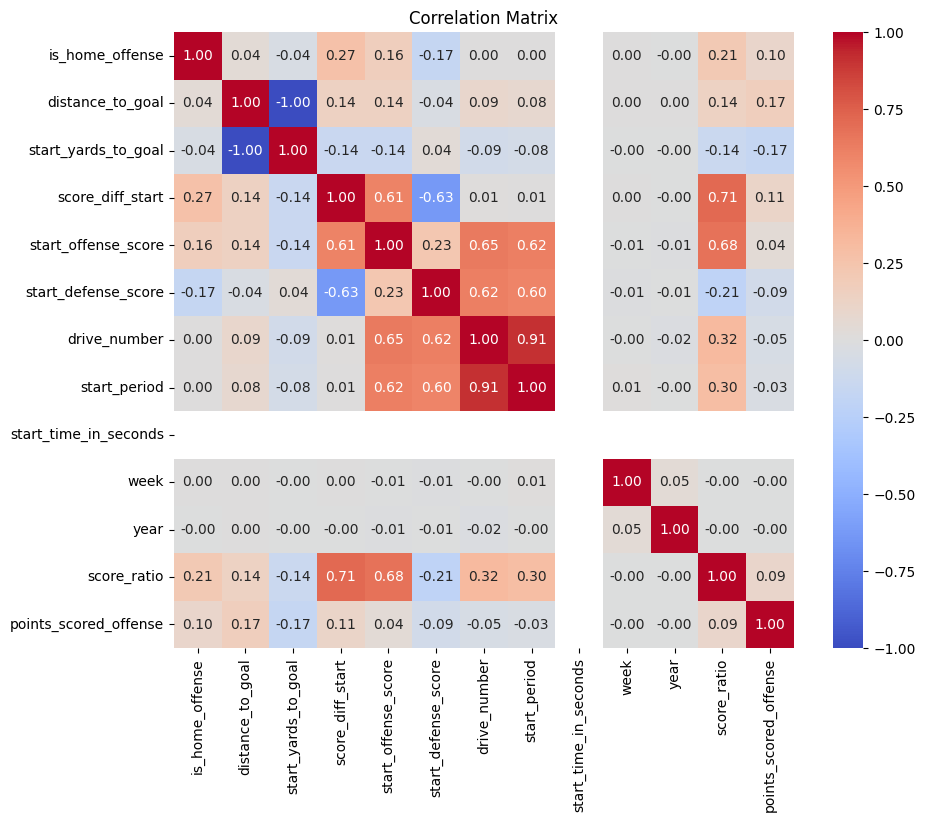

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("drives.csv")

# Define the target and candidate features
features = ['is_home_offense', 'distance_to_goal', 'start_yards_to_goal',
            'score_diff_start', 'start_offense_score', 'start_defense_score',
            'drive_number', 'start_period', 'start_time_in_seconds', 'week', 'year']
target = 'points_scored_offense'

# Optionally, create an engineered feature for score context:
df['score_ratio'] = df['start_offense_score'] / (df['start_offense_score'] + df['start_defense_score'] + 1)

# Add the engineered feature to the candidate list if desired:
features.append('score_ratio')

# Drop rows with missing values in these columns
df_corr = df[features + [target]].dropna()

# Compute the correlation matrix
corr_matrix = df_corr.corr()

# Extract correlations with the target
target_corr = corr_matrix[target].drop(target)
print("Correlation with", target)
print(target_corr.sort_values(ascending=False))

# Plot the full correlation matrix for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Feature Importances:
drive_number             0.162630
week                     0.151409
score_ratio              0.111145
start_yards_to_goal      0.103148
distance_to_goal         0.102511
score_diff_start         0.088320
start_defense_score      0.081851
start_offense_score      0.080591
year                     0.067152
start_period             0.036999
is_home_offense          0.014245
start_time_in_seconds    0.000000
dtype: float64


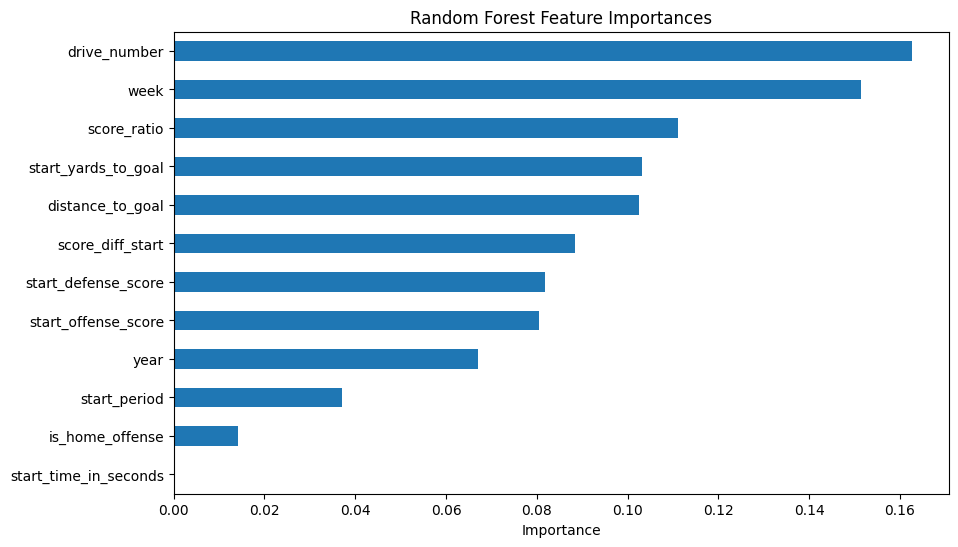

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle infinite or very large values in the dataset
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Standardize features (recommended for continuous variables)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit a RandomForest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=features)
print("Feature Importances:")
print(importances.sort_values(ascending=False))

# Plot the importances
plt.figure(figsize=(10, 6))
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. Load the Data
# ---------------------------
df = pd.read_csv("drives.csv")

# ---------------------------
# 2. Clean and Filter the Data
# ---------------------------
# List of required columns (avoid leakage columns like end scores)
required_cols = [
    'points_scored_offense', 'is_home_offense', 'distance_to_goal', 'score_diff_start',
    'drive_number', 'start_period', 'start_yardline', 'start_offense_score',
    'start_defense_score', 'week', 'year', 'start_time_in_seconds'
]

# Drop rows missing these values
df = df.dropna(subset=required_cols).copy()

# Optionally, remove drives with unrealistic offensive scores (e.g., >15 points)
df = df[df["points_scored_offense"] <= 15]

# ---------------------------
# 3. Remove Redundant or Uninformative Features
# ---------------------------
# If 'start_yards_to_goal' exists and is redundant with 'distance_to_goal', drop it.
if 'start_yards_to_goal' in df.columns:
    df = df.drop(columns=['start_yards_to_goal'])
# If 'start_time_in_seconds' is not useful (e.g., constant or very noisy), drop it.
if 'start_time_in_seconds' in df.columns:
    df = df.drop(columns=['start_time_in_seconds'])

# ---------------------------
# 4. Create Engineered Features
# ---------------------------
# Create a score_ratio feature to capture relative scoring context.
df['score_ratio'] = df['start_offense_score'] / (df['start_offense_score'] + df['start_defense_score'] + 1)
# Create an interaction term between home advantage and field position.
df['home_field_interaction'] = df['is_home_offense'] * df['distance_to_goal']
# Create a red_zone indicator (1 if distance_to_goal <= 20, else 0)
df['red_zone'] = (df['distance_to_goal'] <= 20).astype(int)

# ---------------------------
# 5. Define the Final Feature List and Target
# ---------------------------
# We now use a simplified set of predictors.
features = [
    'is_home_offense',          # binary
    'distance_to_goal',         # continuous
    'score_diff_start',         # continuous
    'drive_number',             # continuous (or ordinal)
    'start_period',             # ordinal
    'start_yardline',           # continuous
    'start_offense_score',      # continuous
    'start_defense_score',      # continuous
    'week',                     # ordinal/continuous
    'year',                     # ordinal/continuous
    'score_ratio',              # continuous
    'home_field_interaction',   # continuous
    'red_zone'                  # binary
]
target = 'points_scored_offense'

# ---------------------------
# 6. Standardize Continuous Variables
# ---------------------------
# We assume that binary variables are: is_home_offense and red_zone.
binary_vars = ['is_home_offense', 'red_zone']
# All other features are treated as continuous.
continuous_vars = [col for col in features if col not in binary_vars]

# Handle infinite or very large values in the dataset
df[continuous_vars] = df[continuous_vars].replace([np.inf, -np.inf], np.nan).fillna(0)

# Initialize the scaler and standardize continuous predictors
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

# ---------------------------
# 7. (Optional) Inspect the Data
# ---------------------------
print("Cleaned & Engineered Data (first few rows):")
print(df[features].head())

# Now you can proceed with your modeling using the cleaned, non‐redundant, and standardized features.

Cleaned & Engineered Data (first few rows):
   is_home_offense  distance_to_goal  score_diff_start  drive_number  \
0                1         -0.288468          0.068429     -1.595761   
1                0         -0.816515         -0.378571     -1.460420   
2                1         -0.581828          0.515430     -1.325080   
3                0          0.532937         -0.378571     -1.189739   
4                1          0.650281          0.515430     -1.054398   

   start_period  start_yardline  start_offense_score  start_defense_score  \
0     -1.313466       -0.979326            -1.040542             -1.10347   
1     -1.313466        1.261540            -1.040542             -0.55506   
2     -1.313466       -1.169230            -0.480822             -1.10347   
3     -1.313466        0.387982            -1.040542             -0.55506   
4     -1.313466       -0.371633            -0.480822             -1.10347   

       week      year  score_ratio  home_field_interaction  

Correlation with points_scored_offense
distance_to_goal          0.167211
home_field_interaction    0.150919
score_diff_start          0.109691
is_home_offense           0.096702
score_ratio               0.094427
start_offense_score       0.042941
week                     -0.002078
year                     -0.003745
start_period             -0.032638
drive_number             -0.050646
red_zone                 -0.090821
start_defense_score      -0.092433
start_yardline                 NaN
Name: points_scored_offense, dtype: float64


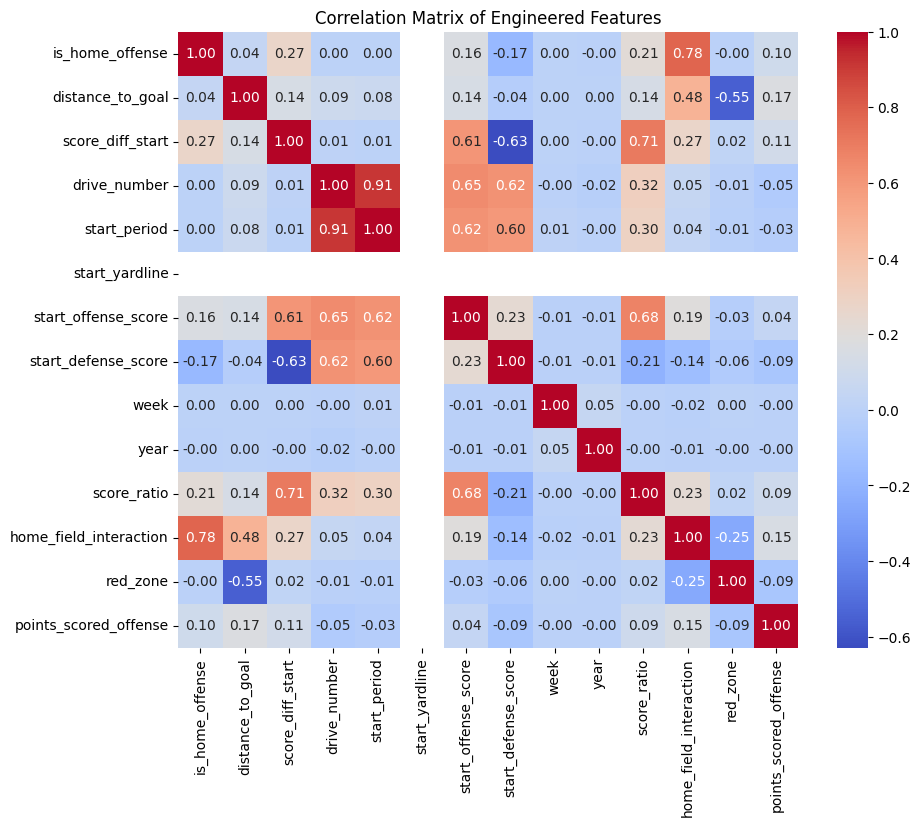

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the required columns are present in df_model
required_columns = ['start_yardline', 'home_field_interaction', 'red_zone']
for col in required_columns:
	if col not in df_model.columns:
		print(f"Warning: '{col}' is not in df_model. Creating it with default values.")
		if col == 'home_field_interaction':
			df_model[col] = df_model['is_home_offense'] * df_model['distance_to_goal']
		elif col == 'red_zone':
			df_model[col] = (df_model['distance_to_goal'] <= 20).astype(int)
		else:
			df_model[col] = 0  # Default value for missing columns

# Using the cleaned & engineered dataframe (df_model)
selected_features = features + [target]
df_subset = df_model[selected_features].dropna()

# Compute the correlation matrix
corr_matrix = df_subset.corr()

# Print correlations with the target
target_corr = corr_matrix[target].drop(target)
print("Correlation with", target)
print(target_corr.sort_values(ascending=False))

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Engineered Features")
plt.show()

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load and Clean Drive Data
# ---------------------------
df = pd.read_csv("drives.csv")

# Define required columns (exclude leakage columns such as end scores)
required_cols = [
    'points_scored_offense', 'offense', 'defense', 'is_home_offense',
    'distance_to_goal', 'score_diff_start', 'drive_number', 'start_period',
    'start_yardline', 'start_offense_score', 'start_defense_score', 'week', 'year'
]
df = df.dropna(subset=required_cols).copy()

# Filter out unrealistic offensive scores (for example, >15 points)
df = df[df["points_scored_offense"] <= 15]

# ---------------------------
# 2. Create Aggregated Team-Level Features
# ---------------------------
# Aggregate offensive team statistics (from the drive data)
team_offense_stats = df.groupby("offense").agg(
    avg_points_offense=("points_scored_offense", "mean"),
    std_points_offense=("points_scored_offense", "std"),
    avg_drive_yards=("start_yardline", "mean")  # or use another measure if available
).reset_index()

# Aggregate defensive team statistics: here we treat the points scored against as a proxy.
team_defense_stats = df.groupby("defense").agg(
    avg_points_defense=("points_scored_offense", "mean"),
    std_points_defense=("points_scored_offense", "std")
).reset_index()

# Merge the team-level stats back into the drive-level data.
df = df.merge(team_offense_stats, left_on="offense", right_on="offense", how="left")
df = df.merge(team_defense_stats, left_on="defense", right_on="defense", how="left")

# ---------------------------
# 3. (Optional) Create Additional Engineered Features
# ---------------------------
# Create a score_ratio as an indicator of the offensive scoring context.
df['score_ratio'] = df['start_offense_score'] / (df['start_offense_score'] + df['start_defense_score'] + 1)
# Create an interaction term for home-field advantage and field position.
df['home_field_interaction'] = df['is_home_offense'] * df['distance_to_goal']
# Create a red-zone indicator (assume red zone if distance_to_goal <= 20)
df['red_zone'] = (df['distance_to_goal'] <= 20).astype(int)

# ---------------------------
# 4. Define the Feature Set and Target
# ---------------------------
# For this example, we use a set of drive-level features plus the aggregated team-level features.
features = [
    'is_home_offense', 'distance_to_goal', 'score_diff_start', 'drive_number', 'start_period',
    'start_yardline', 'start_offense_score', 'start_defense_score', 'week', 'year',
    'score_ratio', 'home_field_interaction', 'red_zone',
    'avg_points_offense', 'std_points_offense', 'avg_drive_yards',
    'avg_points_defense', 'std_points_defense'
]
target = 'points_scored_offense'

# Replace infinite values with NaN
df[features] = df[features].replace([np.inf, -np.inf], np.nan)

# Remove rows with missing values in the features (if any)
df_model = df[features + [target]].dropna()

# ---------------------------
# 5. Standardize Continuous Predictors
# ---------------------------
# Identify which variables are continuous.
binary_vars = ['is_home_offense', 'red_zone']
continuous_vars = [col for col in features if col not in binary_vars]

scaler = StandardScaler()
df_model[continuous_vars] = scaler.fit_transform(df_model[continuous_vars])

# ---------------------------
# 6. Split Data into Train and Test Sets (for example by season)
# ---------------------------
# Here, we use a simple random split; for season‐based splits, adjust accordingly.
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# 7. Fit a Regression Model (e.g., Ridge)
# ---------------------------
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# ---------------------------
# 8. (Optional) Examine Team Coefficients
# ---------------------------
# Suppose you previously built a model using dummy-coded team IDs to capture team effects.
# If you have team coefficients (e.g., from a mixed effects model) stored in a file, you can merge
# them with these aggregated features to see if adding these team-level aggregates improves predictions.
# For example, compare the correlation between team coefficients estimated on training data
# versus testing data.

Regression Model Performance:
RMSE: 2.8770
MAE: 2.4584
R²: 0.0863


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Load your data and select features (adjust as needed)
df = pd.read_csv("drives.csv")
features = ['is_home_offense', 'distance_to_goal', 'score_diff_start', 
            'drive_number', 'start_period', 'start_yardline', 
            'start_offense_score', 'start_defense_score', 'week', 'year']
target = 'points_scored_offense'

# Drop rows with missing values
df = df.dropna(subset=features + [target]).copy()
# Filter unrealistic scores
df = df[df[target] <= 15]

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize continuous predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Bayesian Ridge Regression with uncertainty estimates
bayes_model = BayesianRidge(compute_score=True)
bayes_model.fit(X_train_scaled, y_train)

# Get predictions along with standard deviations
y_pred, y_std = bayes_model.predict(X_test_scaled, return_std=True)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Bayesian Ridge RMSE: {rmse:.4f}")
print("Example prediction with uncertainty:")
print("Predicted points:", y_pred[:5])
print("Prediction std dev:", y_std[:5])

Bayesian Ridge RMSE: 2.9399
Example prediction with uncertainty:
Predicted points: [2.62142867 2.75303459 2.42529968 3.93490999 2.40433342]
Prediction std dev: [2.95887511 2.95889988 2.95911175 2.95944197 2.9588093 ]


In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load and prepare data (as before)
df = pd.read_csv("drives.csv")
features = ['is_home_offense', 'distance_to_goal', 'score_diff_start', 
            'drive_number', 'start_period', 'start_yardline', 
            'start_offense_score', 'start_defense_score', 'week', 'year']
target = 'points_scored_offense'
df = df.dropna(subset=features + [target]).copy()
df = df[df[target] <= 15]

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM quantile model for the 0.10 quantile (lower bound of prediction interval)
params_lower = {
    'objective': 'quantile',
    'alpha': 0.10,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'verbose': -1,
    'seed': 42
}
lgb_model_lower = lgb.LGBMRegressor(**params_lower)
lgb_model_lower.fit(X_train_scaled, y_train)
y_pred_lower = lgb_model_lower.predict(X_test_scaled)

# LightGBM quantile model for the 0.90 quantile (upper bound)
params_upper = {
    'objective': 'quantile',
    'alpha': 0.90,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'verbose': -1,
    'seed': 42
}
lgb_model_upper = lgb.LGBMRegressor(**params_upper)
lgb_model_upper.fit(X_train_scaled, y_train)
y_pred_upper = lgb_model_upper.predict(X_test_scaled)

# Also build a mean model for point predictions
params_mean = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'verbose': -1,
    'seed': 42
}
lgb_model_mean = lgb.LGBMRegressor(**params_mean)
lgb_model_mean.fit(X_train_scaled, y_train)
y_pred_mean = lgb_model_mean.predict(X_test_scaled)

rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
print(f"LightGBM Mean Model RMSE: {rmse_mean:.4f}")

# Print an example of prediction intervals for the first 5 instances
for i in range(5):
    lower = y_pred_lower[i]
    mean = y_pred_mean[i]
    upper = y_pred_upper[i]
    print(f"Instance {i}: Predicted Mean: {mean:.2f}, 10th quantile: {lower:.2f}, 90th quantile: {upper:.2f}")

/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Mean Model RMSE: 2.9170
Instance 0: Predicted Mean: 3.33, 10th quantile: 0.00, 90th quantile: 7.00
Instance 1: Predicted Mean: 2.48, 10th quantile: 0.00, 90th quantile: 7.00
Instance 2: Predicted Mean: 1.91, 10th quantile: 0.00, 90th quantile: 7.00
Instance 3: Predicted Mean: 4.12, 10th quantile: 0.00, 90th quantile: 7.00
Instance 4: Predicted Mean: 2.96, 10th quantile: 0.00, 90th quantile: 7.00


/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Ridge Regression Performance:
RMSE: 2.9399
MAE:  2.5502
R²:   0.0450

Example of Drives with High Prediction Errors:
       actual_points  predicted_points  residual
15935              7          1.934134  5.065866
15167              7          2.039767  4.960233
48302              6          0.620254  5.379746
8450              10          2.572372  7.427628
9423               7          1.867593  5.132407
59914              7          1.684862  5.315138
46772              7          2.014119  4.985881
5700               7          1.946237  5.053763
33015              7          1.897116  5.102884
39488              8          1.451418  6.548582


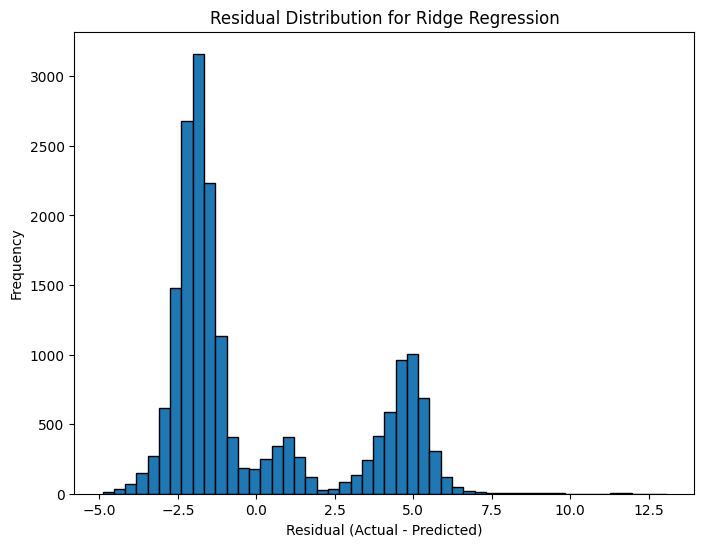

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load and Clean Data
# ---------------------------
# Load your drive-level dataset
df = pd.read_csv("drives.csv")

# Define the required columns (avoid leakage columns such as end scores, drive_result, etc.)
required_cols = [
    'points_scored_offense', 'is_home_offense', 'distance_to_goal', 'score_diff_start',
    'drive_number', 'start_period', 'start_yardline', 'start_offense_score',
    'start_defense_score', 'week', 'year'
]
df = df.dropna(subset=required_cols).copy()

# Filter out drives with unrealistic offensive scores (for example, >15 points)
df = df[df["points_scored_offense"] <= 15]

# ---------------------------
# 2. Define Features and Target
# ---------------------------
features = ['is_home_offense', 'distance_to_goal', 'score_diff_start', 'drive_number',
            'start_period', 'start_yardline', 'start_offense_score', 'start_defense_score', 'week', 'year']
target = 'points_scored_offense'

X = df[features]
y = df[target]

# ---------------------------
# 3. Standardize Continuous Predictors
# ---------------------------
# We assume is_home_offense is binary; standardize the rest.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 4. Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ---------------------------
# 5. Fit Ridge Regression Model
# ---------------------------
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test)

# ---------------------------
# 6. Evaluate the Model
# ---------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ridge Regression Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# ---------------------------
# 7. Identify Drives with High Prediction Errors
# ---------------------------
# Compute residuals (error = actual - predicted)
residuals = y_test - y_pred

# Flag drives where the absolute error is above the 90th percentile
error_threshold = np.percentile(np.abs(residuals), 90)
high_error_idx = np.abs(residuals) > error_threshold

# Extract these problematic drives using their original indices
df_problematic = df.loc[y_test.index[high_error_idx]].copy()
df_problematic = df_problematic.assign(
    actual_points = y_test[high_error_idx],
    predicted_points = y_pred[high_error_idx],
    residual = residuals[high_error_idx]
)

print("\nExample of Drives with High Prediction Errors:")
print(df_problematic[['actual_points', 'predicted_points', 'residual']].head(10))

# ---------------------------
# 8. Plot the Residual Distribution
# ---------------------------
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title("Residual Distribution for Ridge Regression")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

Ridge Regression Performance:
RMSE: 1.7354
MAE:  1.3015
R²:   0.6673

Drives with High Prediction Errors (Top 10% Residuals):
       actual_points  predicted_points   residual
10606              0          3.324407  -3.324407
5954               0          3.236035  -3.236035
47423              0          2.929262  -2.929262
8450              10         -0.190397  10.190397
24093              0          6.244329  -6.244329
22679              0          3.095375  -3.095375
39488              8          2.152823   5.847177
4834               0          3.931022  -3.931022
17434              0          3.089423  -3.089423
49400              7          3.636069   3.363931


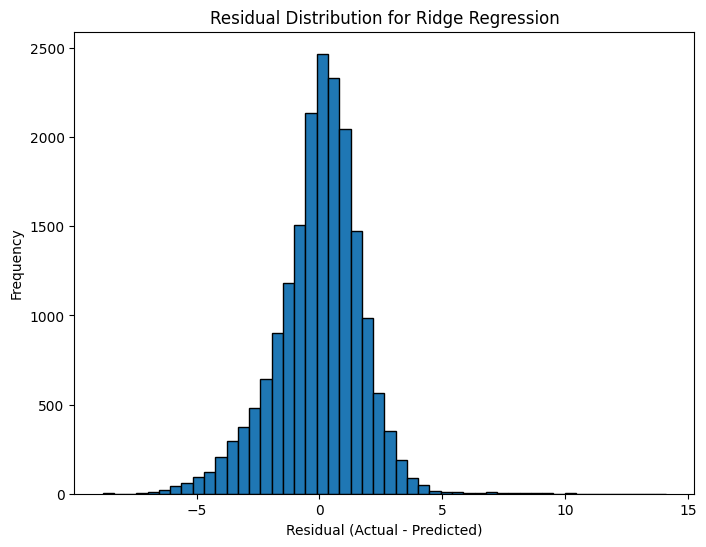

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load the Data
# ---------------------------
df = pd.read_csv("drives.csv")

# ---------------------------
# 2. Data Cleaning and Filtering
# ---------------------------
# Define required columns – here we assume these are available.
required_cols = [
    'points_scored_offense', 'yards', 'yards_gained_per_play', 'plays',
    'offense_defense_matchup_avg_points_by_offense_points', 'end_offense_score',
    'distance_to_goal', 'matchup_avg_yards', 'score_diff_start'
]
df = df.dropna(subset=required_cols).copy()

# Optionally, filter out unrealistic drives (for instance, if points > 15 are implausible)
df = df[df['points_scored_offense'] <= 15]

# ---------------------------
# 3. Select Features Based on Correlation
# ---------------------------
# (Based on your correlations, we choose the top 8 features)
selected_features = [
    'yards', 
    'yards_gained_per_play', 
    'plays', 
    'offense_defense_matchup_avg_points_by_offense_points',
    'end_offense_score', 
    'distance_to_goal', 
    'matchup_avg_yards', 
    'score_diff_start'
]
target = 'points_scored_offense'

# ---------------------------
# 4. Split the Data
# ---------------------------
X = df[selected_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# 5. Standardize the Continuous Features
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 6. Fit a Ridge Regression Model
# ---------------------------
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred = ridge_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ridge Regression Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# ---------------------------
# 7. Identify Drives with High Prediction Errors
# ---------------------------
residuals = y_test - y_pred
error_threshold = np.percentile(np.abs(residuals), 90)  # top 10% errors
high_error_idx = np.abs(residuals) > error_threshold

# Get a sample of drives with high errors
df_problematic = df.loc[y_test.index[high_error_idx]].copy()
df_problematic = df_problematic.assign(
    actual_points=y_test[high_error_idx],
    predicted_points=y_pred[high_error_idx],
    residual=residuals[high_error_idx]
)

print("\nDrives with High Prediction Errors (Top 10% Residuals):")
print(df_problematic[['actual_points', 'predicted_points', 'residual']].head(10))

# ---------------------------
# 8. Plot the Residual Distribution
# ---------------------------
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title("Residual Distribution for Ridge Regression")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

In [1]:
# %% [code]
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Load the data ---
df = pd.read_csv('drives.csv')

# For this example, assume the dataset already has a column "drive_result" 
# that specifies the outcome of the drive (e.g., "fg", "punt", "td").
# If not, you could derive it based on points scored, for example:
# df['drive_result'] = df['points_scored_offense'].apply(lambda x: 'fg' if x == 3 else ('td' if x >= 6 else 'punt'))

# --- 2. Define features ---
features = ['offense_idx', 'defense_idx', 'score_diff_start', 'is_home_offense', 
            'distance_to_goal', 'score_diff_start_off_adv', 'score_diff_start_def_adv']

# --- 3. Split Data by Year ---
# Training data: 2023 and 2024; Test data: 2022
df_train = df[df['year'].isin([2023, 2024])].copy()
df_test  = df[df['year'] == 2022].copy()

# --- 4. Prepare Feature Matrices with One-Hot Encoding ---
# Convert categorical features to string and one-hot encode.
X_train = pd.get_dummies(df_train[features].astype(str))
X_test  = pd.get_dummies(df_test[features].astype(str))
# Align columns so that both training and test sets have the same features.
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Target variable: drive result (categorical)
y_train = df_train['drive_result']
y_test  = df_test['drive_result']

# --- 5. Train a Multinomial Logistic Regression Model ---
clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate classification performance
acc = accuracy_score(y_test, y_pred)
print("Drive Result Classification Accuracy:", acc)
print(classification_report(y_test, y_pred))

# --- 6. Map Drive Result to Points ---
# Define a mapping for drive outcomes to points.
# Adjust these values as per your league or data specifics.
drive_points_mapping = {
    'fg': 3,    # Field Goal is worth 3 points
    'td': 7,    # Touchdown (with extra point) is assumed to be 7 points
    'punt': 0   # Punt yields 0 points
    # Add additional outcomes if available.
}

# Create a new column for predicted drive result and the associated predicted points.
df_test['predicted_drive_result'] = y_pred
df_test['predicted_points'] = df_test['predicted_drive_result'].map(drive_points_mapping)

# --- 7. Display a Sample of Predictions ---
print("\nSample Predictions:")
print(df_test[['year', 'drive_result', 'predicted_drive_result', 
               'points_scored_offense', 'predicted_points']].head(20))

/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Drive Result Classification Accuracy: 0.4115703270916144
                    precision    recall  f1-score   support

        BLOCKED FG       0.00      0.00      0.00         2
      BLOCKED PUNT       0.00      0.00      0.00         3
             DOWNS       0.16      0.02      0.03      1459
          DOWNS TD       0.00      0.00      0.00         1
END OF 4TH QUARTER       0.00      0.00      0.00        69
       END OF GAME       0.14      0.03      0.05       632
       END OF HALF       0.00      0.00      0.00       615
    END OF HALF TD       0.00      0.00      0.00         1
                FG       0.26      0.03      0.05      1898
             FG TD       0.00      0.00      0.00         1
            FUMBLE       0.00      0.00      0.00       870
  FUMBLE RETURN TD       0.00      0.00      0.00        57
         FUMBLE TD       0.00      0.00      0.00         9
               INT       0.09      0.00      0.00      1205
            INT TD       0.00      0.00   

/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ravikurella/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Team coefficients saved to team_coefficients.csv
Empty DataFrame
Columns: [team_id, team_name, train_offense_coeff, test_offense_coeff, train_defense_coeff, test_defense_coeff]
Index: []
Correlation between train and test offense coefficients: 0.448
Correlation between train and test points per drive: 0.742


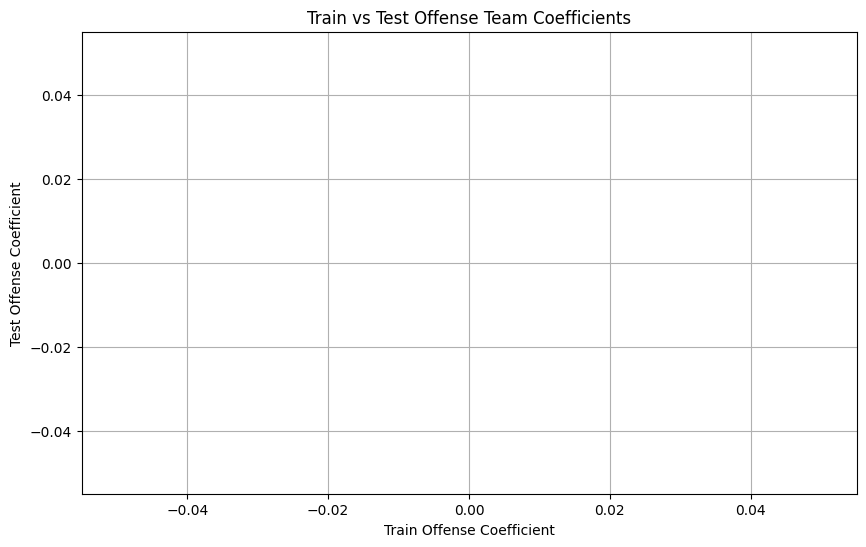

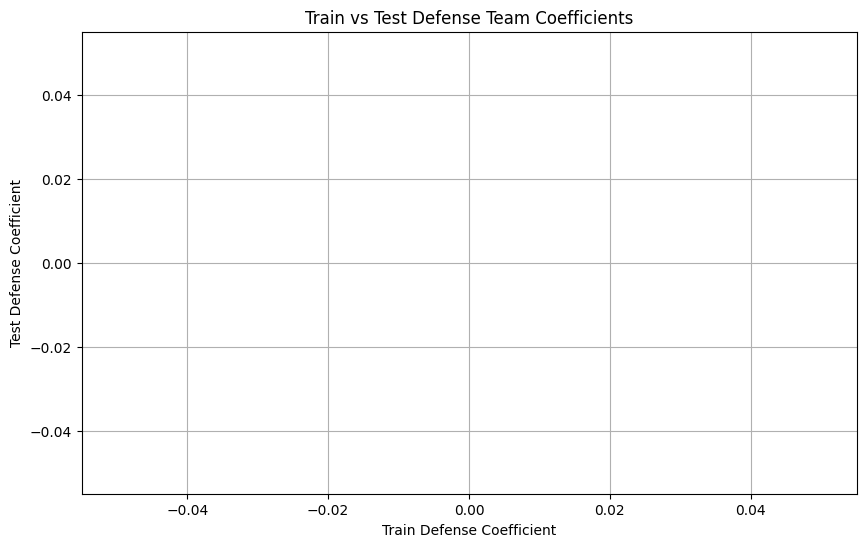


Model 1 (Situational Features Only)
Test Accuracy: 0.963
Test RMSE: 0.17


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by LogisticRegression.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc

# =============================================================================
# 1. TEAM COEFFICIENT ESTIMATION (Model 0)
# =============================================================================

# Load the drives data
df = pd.read_csv('drives.csv')

# Split data by week: train (weeks < 9) and test (weeks > 8)
df_train = df[df['week'] < 9].copy()
df_test  = df[df['week'] > 8].copy()

# -----------------------------------------------------------------------------
# Filter teams with at least 25 drives in both splits
# -----------------------------------------------------------------------------
off_train_counts = df_train['offense_idx'].value_counts()
off_test_counts  = df_test['offense_idx'].value_counts()
valid_off_teams = off_train_counts[off_train_counts >= 25].index.intersection(off_test_counts[off_test_counts >= 25])

def_train_counts = df_train['defense_idx'].value_counts()
def_test_counts  = df_test['defense_idx'].value_counts()
valid_def_teams = def_train_counts[def_train_counts >= 25].index.intersection(def_test_counts[def_test_counts >= 25])

df_train_off = df_train[df_train['offense_idx'].isin(valid_off_teams)].copy()
df_test_off  = df_test[df_test['offense_idx'].isin(valid_off_teams)].copy()
df_train_def = df_train[df_train['defense_idx'].isin(valid_def_teams)].copy()
df_test_def  = df_test[df_test['defense_idx'].isin(valid_def_teams)].copy()

# Define features and targets for drive-level regression
features = ['start_period', 'score_diff_start', 'is_home_offense', 'distance_to_goal', 'goal_to_go']
offense_target = 'points_scored_offense'
defense_target = 'points_scored_defense'

# ------
# OFFENSE COEFFICIENTS
# ------
offense_encoded_train = pd.get_dummies(df_train_off['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)
offense_encoded_test  = pd.get_dummies(df_test_off['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)

X_train_off = pd.concat([offense_encoded_train, df_train_off[features].reset_index(drop=True)], axis=1)
X_test_off  = pd.concat([offense_encoded_test,  df_test_off[features].reset_index(drop=True)], axis=1)
X_test_off  = X_test_off.reindex(columns=X_train_off.columns, fill_value=0)

y_train_off = df_train_off[offense_target].reset_index(drop=True)
y_test_off  = df_test_off[offense_target].reset_index(drop=True)

ridge_off = Ridge(alpha=1.0)
ridge_off.fit(X_train_off, y_train_off)
n_offense = offense_encoded_train.shape[1]
offense_coeff_train = pd.Series(ridge_off.coef_[:n_offense], index=offense_encoded_train.columns)

ridge_off_test = Ridge(alpha=1.0)
ridge_off_test.fit(X_test_off, y_test_off)
offense_coeff_test = pd.Series(ridge_off_test.coef_[:n_offense], index=offense_encoded_train.columns)

# Map team IDs to names
team_name_map_off = df[['offense_idx', 'offense']].drop_duplicates().set_index('offense_idx')['offense'].astype(str).to_dict()

offense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in offense_coeff_train.index],
    'team_name': [team_name_map_off.get(int(col.split('_')[-1]), 'Unknown') for col in offense_coeff_train.index],
    'train_offense_coeff': offense_coeff_train.values,
    'test_offense_coeff': offense_coeff_test.values
})

# ------
# DEFENSE COEFFICIENTS
# ------
defense_encoded_train = pd.get_dummies(df_train_def['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)
defense_encoded_test  = pd.get_dummies(df_test_def['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)

X_train_def = pd.concat([defense_encoded_train, df_train_def[features].reset_index(drop=True)], axis=1)
X_test_def  = pd.concat([defense_encoded_test,  df_test_def[features].reset_index(drop=True)], axis=1)
X_test_def  = X_test_def.reindex(columns=X_train_def.columns, fill_value=0)

y_train_def = df_train_def[defense_target].reset_index(drop=True)
y_test_def  = df_test_def[defense_target].reset_index(drop=True)

ridge_def = Ridge(alpha=1.0)
ridge_def.fit(X_train_def, y_train_def)
n_defense = defense_encoded_train.shape[1]
defense_coeff_train = pd.Series(ridge_def.coef_[:n_defense], index=defense_encoded_train.columns)

ridge_def_test = Ridge(alpha=1.0)
ridge_def_test.fit(X_test_def, y_test_def)
defense_coeff_test = pd.Series(ridge_def_test.coef_[:n_defense], index=defense_encoded_train.columns)

team_name_map_def = df[['defense_idx', 'defense']].drop_duplicates().set_index('defense_idx')['defense'].astype(str).to_dict()

defense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in defense_coeff_train.index],
    'team_name': [team_name_map_def.get(int(col.split('_')[-1]), 'Unknown') for col in defense_coeff_train.index],
    'train_defense_coeff': defense_coeff_train.values,
    'test_defense_coeff': defense_coeff_test.values
})

# ------
# Merge coefficients and save
# ------
team_ratings = pd.merge(offense_coeff_df, defense_coeff_df, on=['team_id', 'team_name'], how='outer')
team_ratings_clean = team_ratings.dropna()  # Option: Impute NaNs if needed.
team_ratings_clean.to_csv("team_coefficients.csv", index=False)
print("Team coefficients saved to team_coefficients.csv")
print(team_ratings_clean.head())

# -----------------------------------------------------------------------------
# Compare Team Coefficients Correlation and Points-per-Drive Correlation
# -----------------------------------------------------------------------------
# Compute correlation between train and test team offensive coefficients
offense_coef_corr = np.corrcoef(offense_coeff_train, offense_coeff_test)[0,1]
print("Correlation between train and test offense coefficients:", round(offense_coef_corr, 3))

# Compute points-per-drive (offense) averages in train and test splits
ppd_train = df_train.groupby('offense_idx')['points_scored_offense'].mean()
ppd_test  = df_test.groupby('offense_idx')['points_scored_offense'].mean()
ppd_corr = ppd_train.corr(ppd_test)
print("Correlation between train and test points per drive:", round(ppd_corr, 3))

# Plotting team coefficients (optional)
plt.figure(figsize=(10, 6))
plt.scatter(team_ratings_clean['train_offense_coeff'], team_ratings_clean['test_offense_coeff'], alpha=0.7)
plt.title("Train vs Test Offense Team Coefficients")
plt.xlabel("Train Offense Coefficient")
plt.ylabel("Test Offense Coefficient")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(team_ratings_clean['train_defense_coeff'], team_ratings_clean['test_defense_coeff'], alpha=0.7)
plt.title("Train vs Test Defense Team Coefficients")
plt.xlabel("Train Defense Coefficient")
plt.ylabel("Test Defense Coefficient")
plt.grid(True)
plt.show()

# =============================================================================
# 2. PREDICTIVE MODELING OF 4TH DOWN CONVERSION
#
# We use only 4th down plays for this analysis.
# Model 1: 4th_down_success = yards to go + yards to goal
# Model 2: 4th_down_success = yards to go + yards to goal + team_offense (drive) + team_defense (drive)
#
# Both models are trained on weeks < 9 and tested on weeks > 8.
# =============================================================================

# Filter 4th down plays: assume drive_result "TD" indicates success and "DOWNS" indicates failure.
df_4th = df[df['drive_result'].isin(['TD', 'DOWNS'])].copy()
df_4th['fourth_down_success'] = (df_4th['drive_result'] == 'TD').astype(int)

# ------
# Model 1: Situational Features Only
# ------
X_model1 = df_4th[['yards', 'distance_to_goal']].rename(
    columns={'yards': 'yards_to_go', 'distance_to_goal': 'yards_to_goal'})
y_model1 = df_4th['fourth_down_success']

X_model1_train = X_model1[df_4th['week'] < 9]
X_model1_test  = X_model1[df_4th['week'] > 8]
y_model1_train = y_model1[df_4th['week'] < 9]
y_model1_test  = y_model1[df_4th['week'] > 8]

logreg_model1 = LogisticRegression(max_iter=1000)
logreg_model1.fit(X_model1_train, y_model1_train)
y_pred_model1 = logreg_model1.predict(X_model1_test)
y_prob_model1 = logreg_model1.predict_proba(X_model1_test)[:, 1]

acc_model1 = accuracy_score(y_model1_test, y_pred_model1)
rmse_model1 = mean_squared_error(y_model1_test, y_prob_model1, squared=False)
print("\nModel 1 (Situational Features Only)")
print("Test Accuracy:", round(acc_model1, 3))
print("Test RMSE:", round(rmse_model1, 3))

# ------
# Model 2: Situational Features + Team Coefficients from Model 0
# ------
# Create mapping dictionaries from team_ratings_clean.
off_train_map = {int(row['team_id']): row['train_offense_coeff'] for _, row in team_ratings_clean.iterrows()}
def_train_map = {int(row['team_id']): row['train_defense_coeff'] for _, row in team_ratings_clean.iterrows()}

df_4th['train_off_coef'] = df_4th['offense_idx'].apply(lambda x: off_train_map.get(x, np.nan))
df_4th['train_def_coef'] = df_4th['defense_idx'].apply(lambda x: def_train_map.get(x, np.nan))
df_4th = df_4th.dropna(subset=['train_off_coef', 'train_def_coef'])

X_model2 = df_4th[['yards', 'distance_to_goal', 'train_off_coef', 'train_def_coef']].rename(
    columns={'yards': 'yards_to_go', 'distance_to_goal': 'yards_to_goal'})
y_model2 = df_4th['fourth_down_success']

X_model2_train = X_model2[df_4th['week'] < 9]
X_model2_test  = X_model2[df_4th['week'] > 8]
y_model2_train = y_model2[df_4th['week'] < 9]
y_model2_test  = y_model2[df_4th['week'] > 8]

logreg_model2 = LogisticRegression(max_iter=1000)
logreg_model2.fit(X_model2_train, y_model2_train)
y_pred_model2 = logreg_model2.predict(X_model2_test)
y_prob_model2 = logreg_model2.predict_proba(X_model2_test)[:, 1]

acc_model2 = accuracy_score(y_model2_test, y_pred_model2)
rmse_model2 = mean_squared_error(y_model2_test, y_prob_model2, squared=False)
print("\nModel 2 (Situational Features + Team Coefficients)")
print("Test Accuracy:", round(acc_model2, 3))
print("Test RMSE:", round(rmse_model2, 3))

# Additional Evaluation: ROC Curve for Model 2
fpr, tpr, thresholds = roc_curve(y_model2_test, y_prob_model2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model 2')
plt.legend(loc="lower right")
plt.show()

# =============================================================================
# Summary:
# - Model 0 estimates team-level coefficients (drive coefficients) using weeks < 9 for training
#   and weeks > 8 for testing, and compares the correlation between these coefficients to the correlation
#   of points per drive.
# - Model 1 predicts 4th down success using situational features only.
# - Model 2 adds the team offensive and defensive coefficients as predictors.
#
# Both Model 1 and Model 2 are trained on plays from weeks < 9 and tested on plays from weeks > 8.
# =============================================================================

In [9]:
print("Total 4th down plays before filtering:", len(df_4th))
print("4th down plays with team coefficients (weeks <9):", len(df_4th[df_4th['week'] < 9]))
df_4th_filtered = df_4th.dropna(subset=['train_off_coef', 'train_def_coef'])
print("4th down plays after dropping NaNs:", len(df_4th_filtered[df_4th_filtered['week'] < 9]))

Total 4th down plays before filtering: 0
4th down plays with team coefficients (weeks <9): 0
4th down plays after dropping NaNs: 0


In [10]:
print(df['drive_result'].value_counts())

drive_result
PUNT                          34451
TD                            25748
FG                             8965
DOWNS                          6514
INT                            5658
FUMBLE                         3799
END OF HALF                    2872
MISSED FG                      2782
END OF GAME                    2688
Uncategorized                   650
INT TD                          604
END OF 4TH QUARTER              503
FUMBLE RETURN TD                218
SF                              215
PUNT TD                         163
PUNT RETURN TD                   93
FUMBLE TD                        90
DOWNS TD                         29
MISSED FG TD                     15
RUSHING TD                       11
BLOCKED PUNT                     10
BLOCKED FG                       10
END OF HALF TD                    9
FG GOOD                           7
PASSING TD                        6
KICKOFF                           5
FG TD                             4
FG MISSED      

Total drives after filtering teams with <25 drives: 306525
Team coefficients saved to team_coefficients.csv
  team_id          team_name  train_offense_coeff  test_offense_coeff  \
0       0  Abilene Christian             0.329396           -0.585981   
1       1          Air Force             0.622762            0.564932   
2      10           Arkansas             0.359378            0.286424   
3     100         Louisville             0.503478            0.388523   
4     101              Maine            -0.494651            0.137433   

   train_defense_coeff  test_defense_coeff  
0            -0.064717            0.059329  
1            -0.062007           -0.066871  
2             0.010345            0.052271  
3            -0.025022            0.023216  
4            -0.051410           -0.091106  
Correlation between train and test offense coefficients: 0.605
Correlation between train and test points per drive: 0.778
Total 4th down plays: 13664
Train 4th down plays: 8037
Test 4

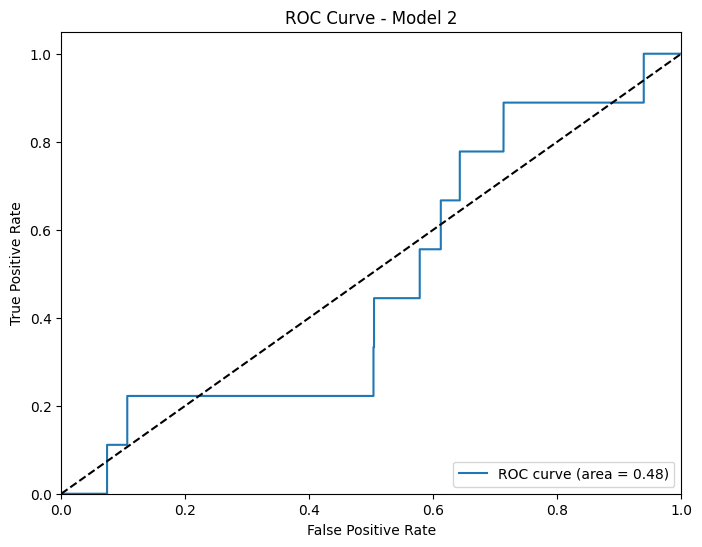

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc

# =============================================================================
# PRE-PROCESSING: REMOVE TEAMS WITH < 25 DRIVES FROM THE ENTIRE DATASET
# =============================================================================

# Load the drives data
df = pd.read_csv('drives.csv')

# Set the threshold: only keep teams with at least 25 drives overall (offense and defense)
threshold = 25

# Compute overall counts for offense and defense
off_counts = df['offense_idx'].value_counts()
def_counts = df['defense_idx'].value_counts()

# Identify teams meeting the threshold in both offense and defense
valid_off_teams = off_counts[off_counts >= threshold].index
valid_def_teams = def_counts[def_counts >= threshold].index

# Filter the entire dataset to include only drives from these teams
df_filtered = df[df['offense_idx'].isin(valid_off_teams) & df['defense_idx'].isin(valid_def_teams)].copy()
print("Total drives after filtering teams with <25 drives:", len(df_filtered))

# =============================================================================
# PART 1: TEAM COEFFICIENT ESTIMATION (Model 0)
# =============================================================================

# Split the filtered data by week: training = weeks < 9, testing = weeks > 8.
df_train = df_filtered[df_filtered['week'] < 9].copy()
df_test  = df_filtered[df_filtered['week'] > 8].copy()

# Define features and targets for drive-level regression
features = ['start_period', 'score_diff_start', 'is_home_offense', 'distance_to_goal', 'goal_to_go']
offense_target = 'points_scored_offense'
defense_target = 'points_scored_defense'

# ------
# OFFENSE COEFFICIENTS
# ------
offense_encoded_train = pd.get_dummies(df_train['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)
offense_encoded_test  = pd.get_dummies(df_test['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)

X_train_off = pd.concat([offense_encoded_train, df_train[features].reset_index(drop=True)], axis=1)
X_test_off  = pd.concat([offense_encoded_test, df_test[features].reset_index(drop=True)], axis=1)
X_test_off  = X_test_off.reindex(columns=X_train_off.columns, fill_value=0)

y_train_off = df_train[offense_target].reset_index(drop=True)
y_test_off  = df_test[offense_target].reset_index(drop=True)

ridge_off = Ridge(alpha=1.0)
ridge_off.fit(X_train_off, y_train_off)
n_offense = offense_encoded_train.shape[1]
offense_coeff_train = pd.Series(ridge_off.coef_[:n_offense], index=offense_encoded_train.columns)

ridge_off_test = Ridge(alpha=1.0)
ridge_off_test.fit(X_test_off, y_test_off)
offense_coeff_test = pd.Series(ridge_off_test.coef_[:n_offense], index=offense_encoded_train.columns)

# Map team IDs to names (assuming columns 'offense_idx' and 'offense' exist)
team_name_map_off = df[['offense_idx', 'offense']].drop_duplicates().set_index('offense_idx')['offense'].astype(str).to_dict()

offense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in offense_coeff_train.index],
    'team_name': [team_name_map_off.get(int(col.split('_')[-1]), 'Unknown') for col in offense_coeff_train.index],
    'train_offense_coeff': offense_coeff_train.values,
    'test_offense_coeff': offense_coeff_test.values
})

# ------
# DEFENSE COEFFICIENTS
# ------
defense_encoded_train = pd.get_dummies(df_train['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)
defense_encoded_test  = pd.get_dummies(df_test['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)

X_train_def = pd.concat([defense_encoded_train, df_train[features].reset_index(drop=True)], axis=1)
X_test_def  = pd.concat([defense_encoded_test, df_test[features].reset_index(drop=True)], axis=1)
X_test_def  = X_test_def.reindex(columns=X_train_def.columns, fill_value=0)

y_train_def = df_train[defense_target].reset_index(drop=True)
y_test_def  = df_test[defense_target].reset_index(drop=True)

ridge_def = Ridge(alpha=1.0)
ridge_def.fit(X_train_def, y_train_def)
n_defense = defense_encoded_train.shape[1]
defense_coeff_train = pd.Series(ridge_def.coef_[:n_defense], index=defense_encoded_train.columns)

ridge_def_test = Ridge(alpha=1.0)
ridge_def_test.fit(X_test_def, y_test_def)
defense_coeff_test = pd.Series(ridge_def_test.coef_[:n_defense], index=defense_encoded_train.columns)

team_name_map_def = df[['defense_idx', 'defense']].drop_duplicates().set_index('defense_idx')['defense'].astype(str).to_dict()

defense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in defense_coeff_train.index],
    'team_name': [team_name_map_def.get(int(col.split('_')[-1]), 'Unknown') for col in defense_coeff_train.index],
    'train_defense_coeff': defense_coeff_train.values,
    'test_defense_coeff': defense_coeff_test.values
})

# ------
# Merge coefficients and save to CSV
# ------
team_ratings = pd.merge(offense_coeff_df, defense_coeff_df, on=['team_id', 'team_name'], how='outer')
team_ratings.to_csv("team_coefficients.csv", index=False)
print("Team coefficients saved to team_coefficients.csv")
print(team_ratings.head())

# -----------------------------------------------------------------------------
# Compare Correlations:
# 1. Correlation between train and test offensive coefficients.
# 2. Correlation between train and test points-per-drive.
# -----------------------------------------------------------------------------
offense_coef_corr = np.corrcoef(offense_coeff_train, offense_coeff_test)[0, 1]
print("Correlation between train and test offense coefficients:", round(offense_coef_corr, 3))

ppd_train = df_train.groupby('offense_idx')['points_scored_offense'].mean()
ppd_test  = df_test.groupby('offense_idx')['points_scored_offense'].mean()
ppd_corr = ppd_train.corr(ppd_test)
print("Correlation between train and test points per drive:", round(ppd_corr, 3))

# =============================================================================
# PART 2: PREDICTIVE MODELING OF 4TH DOWN CONVERSION (Model 1 and Model 2)
# =============================================================================

# For 4th down modeling, use the filtered dataset.
df_4th = df_filtered[df_filtered['drive_result'].isin(['DOWNS', 'DOWNS TD'])].copy()
print("Total 4th down plays:", len(df_4th))

# Create binary target: success = 1 if "DOWNS TD", else 0.
df_4th['fourth_down_success'] = (df_4th['drive_result'] == 'DOWNS TD').astype(int)

# Create the 'yards_to_go' variable as 100 - start_yardline.
if 'start_yardline' in df_4th.columns:
    df_4th['yards_to_go'] = 100 - df_4th['start_yardline']
else:
    print("Warning: 'start_yardline' column not found. Check your dataset.")

# Split 4th down plays: Training = weeks < 9, Testing = weeks > 8.
df_4th_train = df_4th[df_4th['week'] < 9].copy()
df_4th_test  = df_4th[df_4th['week'] > 8].copy()
print("Train 4th down plays:", len(df_4th_train))
print("Test 4th down plays:", len(df_4th_test))

# ------
# Model 1: Situational Features Only
# ------
# Use 'yards_to_go' (computed as 100 - start_yardline) and 'distance_to_goal'
X_model1_train = df_4th_train[['yards_to_go', 'distance_to_goal']]
X_model1_test  = df_4th_test[['yards_to_go', 'distance_to_goal']]
y_model1_train = df_4th_train['fourth_down_success']
y_model1_test  = df_4th_test['fourth_down_success']

logreg_model1 = LogisticRegression(max_iter=1000)
logreg_model1.fit(X_model1_train, y_model1_train)
y_pred_model1 = logreg_model1.predict(X_model1_test)
y_prob_model1 = logreg_model1.predict_proba(X_model1_test)[:, 1]

acc_model1 = accuracy_score(y_model1_test, y_pred_model1)
rmse_model1 = mean_squared_error(y_model1_test, y_prob_model1, squared=False)
print("\nModel 1 (Situational Features Only)")
print("Test Accuracy:", round(acc_model1, 3))
print("Test RMSE:", round(rmse_model1, 3))

# ------
# Model 2: Situational Features + Team Coefficients
# ------
# Create mapping dictionaries from team_ratings.
off_train_map = {int(row['team_id']): row['train_offense_coeff'] for _, row in team_ratings.iterrows()}
def_train_map = {int(row['team_id']): row['train_defense_coeff'] for _, row in team_ratings.iterrows()}

# Compute overall means for imputation.
overall_mean_off = team_ratings['train_offense_coeff'].mean()
overall_mean_def = team_ratings['train_defense_coeff'].mean()

# Map the team coefficients to each 4th down play.
df_4th['train_off_coef'] = df_4th['offense_idx'].apply(lambda x: off_train_map.get(x, np.nan))
df_4th['train_def_coef'] = df_4th['defense_idx'].apply(lambda x: def_train_map.get(x, np.nan))

# Explicitly fill any remaining NaNs with the overall means.
df_4th['train_off_coef'] = df_4th['train_off_coef'].fillna(overall_mean_off)
df_4th['train_def_coef'] = df_4th['train_def_coef'].fillna(overall_mean_def)

# Re-split the 4th down plays after imputation.
df_4th_train = df_4th[df_4th['week'] < 9].copy()
df_4th_test  = df_4th[df_4th['week'] > 8].copy()
print("4th down plays after imputation:", len(df_4th))

# Prepare features for Model 2.
X_model2_train = df_4th_train[['yards_to_go', 'distance_to_goal', 'train_off_coef', 'train_def_coef']]
X_model2_test  = df_4th_test[['yards_to_go', 'distance_to_goal', 'train_off_coef', 'train_def_coef']]
y_model2_train = df_4th_train['fourth_down_success']
y_model2_test  = df_4th_test['fourth_down_success']

logreg_model2 = LogisticRegression(max_iter=1000)
logreg_model2.fit(X_model2_train, y_model2_train)
y_pred_model2 = logreg_model2.predict(X_model2_test)
y_prob_model2 = logreg_model2.predict_proba(X_model2_test)[:, 1]

acc_model2 = accuracy_score(y_model2_test, y_pred_model2)
rmse_model2 = mean_squared_error(y_model2_test, y_prob_model2, squared=False)
print("\nModel 2 (Situational Features + Team Coefficients)")
print("Test Accuracy:", round(acc_model2, 3))
print("Test RMSE:", round(rmse_model2, 3))

# Additional Evaluation: ROC Curve for Model 2
fpr, tpr, thresholds = roc_curve(y_model2_test, y_prob_model2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model 2')
plt.legend(loc="lower right")
plt.show()

# =============================================================================
# Summary:
# - Model 0 estimates team-level coefficients using drives from weeks <9 (train)
#   and weeks >8 (test) from the filtered dataset (only teams with ≥25 drives).
# - The correlation between team coefficients and points-per-drive across splits is computed.
# - Model 1 predicts 4th down success using situational features: 'yards_to_go' (computed as 100 - start_yardline)
#   and 'distance_to_goal'.
# - Model 2 augments Model 1 by adding team coefficients, with imputation for missing values.
#
# Both 4th down models are trained on plays from weeks <9 and tested on plays from weeks >8.
# =============================================================================